In [13]:
import numpy as np
from scipy import linalg
from scipy.optimize import brentq # to do root finding
import matplotlib.pyplot as plt
from tabulate import tabulate

In [14]:
# controls: y = [c;h;i;y;r(-1);tby;ca]
# states: x = [k;d(-1);A]
# PS Q3: Cobb-Douglass utility

# parameters
n_state = 3
n_control = 7

σ = 2.0
δ = 0.1
r_star = 0.04
β = 1 / (1+r_star)
α = 0.32
κ = (α/(r_star+δ)) ** (1/(1-α))
# ω = 1.455
d_bar = 0.7442
ϕ = 0.028
ψ = 0.000742
ρ = 0.42
η = 0.0129

# steady state
h_bar = 1/3 #((1-α)*κ**α) ** (1/(ω-1))
k_bar = κ * h_bar
i_bar = δ * k_bar
y_bar = k_bar**α * h_bar**(1-α)
c_bar = -r_star*d_bar + (κ**α)*h_bar - δ*k_bar
r_bar = r_star
tb_bar = r_bar * d_bar
ca_bar = 0.0

# solve for ω given the calibrated value for h_bar
def fbg(x):
    return ( ( (1-α*(1-x))/x )*κ**α - δ*κ ) * h_bar - r_bar * d_bar - ((1-x)/x)*(1-α)*κ**α
ω = brentq(fbg, 0.5, 1.0) # find the root in the interval [0.5,1.0]

In [15]:
ω

0.6567174881355984

In [16]:
# auxilary variables
cb = c_bar**(1-ω) * h_bar**ω # Cobb-Douglas
ϵ_cc = (1-σ)*(1-ω) - 1 # ϵcc = Ucc*c/Uc
ϵ_ch = (1-σ)*ω*( -h_bar/(1-h_bar) ) # ϵch = Uch*h/Uc
ϵ_hc = (1-σ)*(1-ω) # ϵhc = Uhc*c/Uh
ϵ_hh = ( (1-σ)*ω - 1 ) * ( -h_bar/(1-h_bar) ) # ϵhh = Uhh*h/Uh
s_c = c_bar / y_bar
s_i = i_bar / y_bar
s_tb = tb_bar / y_bar

In [17]:
# matrices for the system
f_yprime = np.array([ [0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0],
                      [ϵ_cc,ϵ_ch,0,0,β,0,0],
                      [ϵ_cc,ϵ_ch+β*(1-α)*(r_star+δ),β*ϕ*i_bar,0,0,0,0],
                      [0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0],
                      [0,0,0,0,0,0,0] ])
f_y = np.array([ [ϵ_hc-ϵ_cc,ϵ_hh-ϵ_ch+α,0,0,0,0,0],
                 [0,0,0,0,0,0,0],
                 [c_bar,0,i_bar,-y_bar,d_bar,0,0],
                 [-ϵ_cc,-ϵ_ch,0,0,0,0,0],
                 [-ϵ_cc,-ϵ_ch,-ϕ*i_bar,0,0,0,0],
                 [0,0,0,0,1,0,0],
                 [0,0,δ,0,0,0,0],
                 [0,1-α,0,-1,0,0,0],
                 [s_c,0,s_i,s_tb-1,0,1,0],
                 [0,0,0,0,0,0,y_bar] ])
f_xprime = np.array([ [0,0,0],
                      [0,0,1],
                      [0,-1,0],
                      [0,0,0],
                      [-β*ϕ*i_bar-(1-α)*β*(r_star+δ),0,β*(r_star+δ)],
                      [0,0,0],
                      [-1,0,0],
                      [0,0,0],
                      [0,0,0],
                      [0,1,0] ])
f_x = np.array([ [-α,0,-1],
                 [0,0,-ρ],
                 [0,1+r_star,0],
                 [0,0,0],
                 [ϕ*i_bar,0,0],
                 [0,-ψ,0],
                 [1-δ,0,0],
                 [α,0,1],
                 [0,0,0],
                 [0,-1,0] ])

In [20]:
# matrices for decomposition
A = np.block([f_xprime, f_yprime])
B = np.block([-f_x, -f_y])

# generalized Schur decomposition
AA,BB,alp,beta,Q,Z = linalg.ordqz(A,B,sort='ouc')

# partition for AA, BB, Z
for i in range(np.shape(AA)[0]):
    if abs(BB[i,i]/AA[i,i]) >= 1:
        a11 = AA[:i,:i]
        a22 = AA[i:,i:]
        b11 = BB[:i,:i]
        b22 = BB[i:,i:]
        z11 = Z[:i,:i]
        z22 = Z[i:,i:]
        z12 = Z[:i,i:]
        z21 = Z[i:,:i]
        break
    else:
        continue
# solution
G = - np.linalg.inv(z22.T) @ z12.T # g_x
H = z11 @ np.linalg.inv(a11) @ b11 @ np.linalg.inv(z11) # h_x


RuntimeError: Unable to configure default ndarray.__repr__

In [21]:
# compute moments
F = np.kron(H,H)
I = np.eye(n_state**2)

cov_eps = np.array([0,0,η]).reshape(n_state,1) * np.array([0,0,η])
vec_cov_eps = cov_eps.T.flatten() # stacking columns
vec_cov_x = np.linalg.inv(I-F) @ vec_cov_eps.reshape(n_state**2,1)
cov_x = vec_cov_x.reshape(3,3).T

cov_y = G @ cov_x @ G.T


In [22]:
var = [['c'],
       ['h'],
       ['i'],
       ['y'],
       ['r'],
       ['tb/y'],
       ['ca/y']]

corr_y = np.zeros([n_control,1])
for i in range(n_control):
    corr_y[i] = cov_y[i,3] / np.sqrt(cov_y[i,i]*cov_y[3,3]) # element at (i,j) of cov_y is the covariance

data = np.column_stack([ var, np.sqrt(np.diag(cov_y))*100, corr_y ])
# data
head = ['Variable', 's.d.', 'corr(x,y)']
print(tabulate(data, headers=head, tablefmt=''))


Variable          s.d.    corr(x,y)
----------  ----------  -----------
c            0.846123      0.251908
h            1.79962       0.952884
i           11.2858        0.50531
y            2.78539       1
r            0.0106115     0.40534
tb/y         2.59492       0.447714
ca/y         2.35347       0.362198


In [23]:
# compute IRF
x_init = np.array([0,0,0.01]).reshape(n_state,1)
T = 10

IR_y = np.zeros((T,n_control))
IR_x = np.zeros((T,n_state))
for i in range(T):
    IR_y[i,:] = (G @ np.linalg.matrix_power(H,i) @ x_init).T * 100
    IR_x[i,:] = (np.linalg.matrix_power(H,i) @ x_init).T * 100 

IR_y_ghh = np.load('soe_rbc_irf_y_ghh.npy')
IR_x_ghh = np.load('soe_rbc_irf_x_ghh.npy')

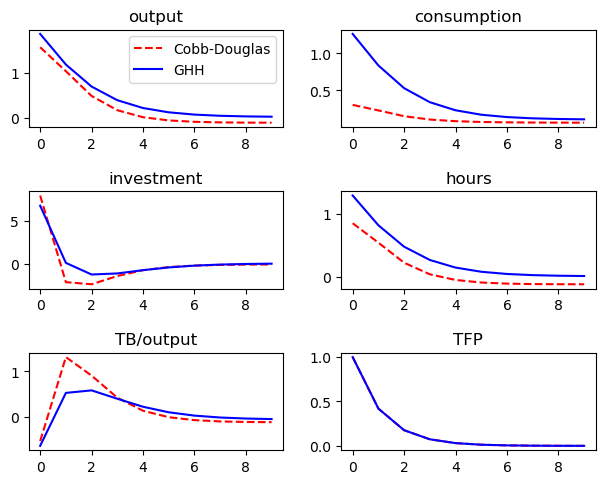

In [24]:
# making plot
time = np.arange(0,T,1)
fig, ax = plt.subplots(3,2) # figure with 3 rows and 2 columns of subplots
fig.tight_layout(h_pad=2.5)

ax[0,0].plot(time, IR_y[:,3], 'r--', IR_y_ghh[:,3], 'b-')
ax[0,1].plot(time, IR_y[:,0], 'r--', IR_y_ghh[:,0], 'b-')
ax[1,0].plot(time, IR_y[:,2], 'r--', IR_y_ghh[:,2], 'b-')
ax[1,1].plot(time, IR_y[:,1], 'r--', IR_y_ghh[:,1], 'b-')
ax[2,0].plot(time, IR_y[:,5], 'r--', IR_y_ghh[:,5], 'b-')
ax[2,1].plot(time, IR_x[:,2], 'r--', IR_x_ghh[:,2], 'b-')

ax[0,0].set_title('output')
ax[0,1].set_title('consumption')
ax[1,0].set_title('investment')
ax[1,1].set_title('hours')
ax[2,0].set_title('TB/output')
ax[2,1].set_title('TFP')

ax[0,0].legend(['Cobb-Douglas', 'GHH'])

# plt.show() # cannot be saved if this command is executed

plt.savefig('soe_rbc_irf_cb_ghh',format='pdf')